In [3]:
# modules
import os
import math
import xarray as xr
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from utils.read_files import read_from_control, make_default_path

In [4]:
# set control file
controlFile = "control_EastRiver.txt"

In [5]:
# Path and filename
fig_path = read_from_control(controlFile,'visualization_folder')
fig_name = 'forcing_remapping_v2.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization', controlFile) # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

# Find location of shapefiles

In [6]:
# Catchment shapefile path & name
catchment_path = read_from_control(controlFile,'catchment_shp_path')
catchment_name = read_from_control(controlFile,'catchment_shp_name')

# Specify default path if needed
if catchment_path == 'default':
    catchment_path = make_default_path('shapefiles/catchment', controlFile) # outputs a Path()
else:
    catchment_path = Path(catchment_path) # make sure a user-specified path is a Path()

# HRU fieldname
shp_hru = read_from_control(controlFile,'catchment_shp_hruid')

In [7]:
shp_hru

'HRU_ID'

# Find forcing files

In [8]:
# Location of merged ERA5 files
forcing_merged_path = read_from_control(controlFile,'forcing_merged_path')

# Specify default path if needed
if forcing_merged_path == 'default':
    forcing_merged_path = make_default_path('forcing/2a_merged_data', controlFile) # outputs a Path()
else:
    forcing_merged_path = Path(forcing_merged_path) # make sure a user-specified path is a Path()

# Find files in folder
forcing_source_files = [forcing_merged_path/file for file in os.listdir(forcing_merged_path) if os.path.isfile(forcing_merged_path/file) and file.endswith('.nc')]
forcing_source_files.sort()

In [9]:
# Location for EASYMORE forcing output
forcing_basin_path = read_from_control(controlFile,'forcing_basin_avg_path')

# Specify default path if needed
if forcing_basin_path == 'default':
    forcing_basin_path = make_default_path('forcing/3_basin_averaged_data',controlFile) # outputs a Path()
else:
    forcing_basin_path = Path(forcing_basin_path) # make sure a user-specified path is a Path()

# Find files in folder
forcing_basin_files = [forcing_basin_path/file for file in os.listdir(forcing_basin_path) if os.path.isfile(forcing_basin_path/file) and file.endswith('.nc')]
forcing_basin_files.sort()

# Load the shapefiles and data

In [10]:
# shapefile
catchment = gpd.read_file(catchment_path/catchment_name)

# netcdfs
forcing_source = xr.open_dataset(forcing_source_files[0])
forcing_basin = xr.open_dataset(forcing_basin_files[0]) 

/tmp/ipykernel_14618/3340664828.py:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  forcing_source = xr.open_dataset(forcing_source_files[0])


# Plot settings and data prep

In [11]:
# What to plot?
var = 'pptrate'
time = 200

In [12]:
# color settings
vmin = math.floor(min(forcing_source[var].isel(time=time).min().values,forcing_basin[var].isel(time=time).min()))
vmax = math.ceil(max(forcing_source[var].isel(time=time).max().values,forcing_basin[var].isel(time=time).max()))

In [25]:
# map basin-averaged netcdf onto shapefile
if (forcing_basin['hruId'] == catchment[shp_hru]).all(): # check that they are in the same order (they should be) kg 
    catchment['plot_var'] = forcing_basin[var].sel(time=slice("2022-12-01", "2023-02-28")).sum(dim="time")  * 86400 # kg/m2 = mm

In [32]:
vmin = 0
vmax = 400

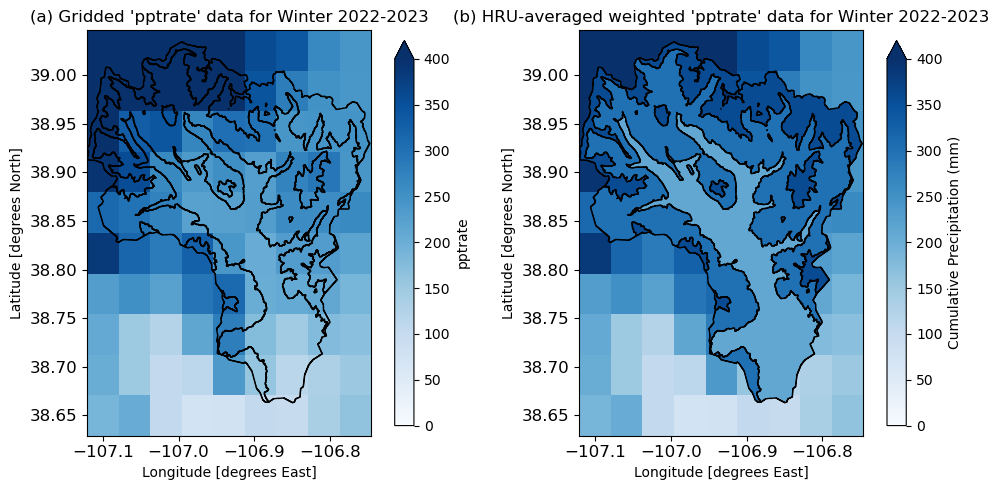

In [45]:
fig, axs = plt.subplots(1,2,figsize=(10,5), tight_layout=True)

# source data + catchment
axId = 0
(forcing_source[var].sel(time=slice("2022-12-01", "2023-02-28")).sum(dim="time")  * 86400).plot(ax=axs[axId],vmin=vmin,vmax=vmax,cbar_kwargs={'shrink': 0.95}, cmap='Blues');
catchment.plot(color='None', edgecolor='k', ax=axs[axId], cmap='Blues');
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
time_str = "Winter 2022-2023"
axs[axId].set_title('(a) Gridded \'{}\' data for {}'.format(var,time_str))
axs[axId].set_xlabel('Longitude [degrees East]');
axs[axId].set_ylabel('Latitude [degrees North]');

# remapped data + catchment
axId = 1
(forcing_source[var].sel(time=slice("2022-12-01", "2023-02-28")).sum(dim="time")  * 86400).plot(ax=axs[axId],vmin=vmin,vmax=vmax,cbar_kwargs={'shrink': 0.95, 
                                                                                                                                              "label":"Cumulative Precipitation (mm)"}, cmap='Blues');
catchment.plot(column='plot_var', edgecolor='k', ax=axs[axId],vmin=vmin,vmax=vmax, cmap='Blues');
axs[axId].set_ylabel('')
axs[axId].set_xlabel('')
time_str = "Winter 2022-2023"
axs[axId].set_title('(b) HRU-averaged weighted \'{}\' data for {}'.format(var,time_str))
axs[axId].set_xlabel('Longitude [degrees East]');
axs[axId].set_ylabel('Latitude [degrees North]');

# increase the size of all labels 
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', labelsize=12)

/home/dlhogan/miniforge3/envs/pc_env/lib/python3.11/site-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<Axes: xlabel='time'>

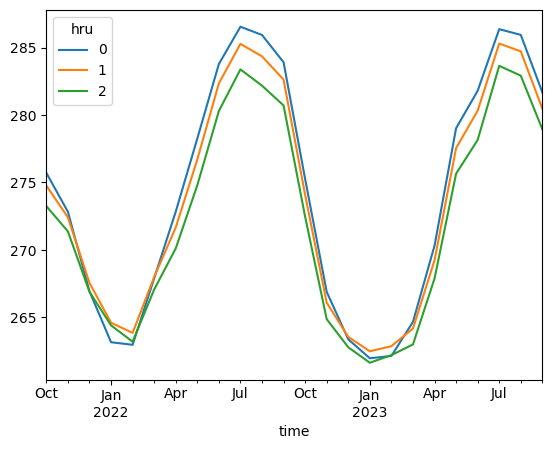

In [24]:
forcing_basin[var].resample(time='1M').mean().to_pandas().plot()